Ce notebook renvoie à la première partie :
**« Vers une écologie des textes et des témoins : modélisation de leur perte et de leur survie  à l’aide d’outils issus de la biologie »**.


# Partie I : Préparation du jeu de données 

On sépare notre jeu de données en deux sous-jeux de données : l'un comprend les textes en prose et l'autre les textes en forme versifiée (section 1.1)

In [1]:
import pandas as pd
from pathlib import Path

# On charge le fichier Excel
file_path = Path('../data/wits_table_tot.xlsx')
df = pd.read_excel(file_path)  # Il manquait cette ligne pour charger le fichier Excel dans le DataFrame

# On vérifie les premières lignes du fichier pour s'assurer des noms de colonnes
print(df.head())

# On filtre les manuscrits avec genre 'poetry'
poetry_df = df[df['workGeneralgenre'] == 'poetry'][['witSignature', 'workTitle', 'workAuthor', 'workGeneralgenre']]

# De même pour  les manuscrits avec genre 'prose'
prose_df = df[df['workGeneralgenre'] == 'prose'][['witSignature', 'workTitle', 'workAuthor', 'workGeneralgenre']]

# On définit le chemin de sortie
output_dir = Path('../data')
output_dir.mkdir(exist_ok=True)

# On spécifie alors les chemins des fichiers de sortie pour chaque jeu de données
poetry_file_path = output_dir / 'poetry.xlsx'
prose_file_path = output_dir / 'prose.xlsx'


# On sauvegarde les DataFrames dans les fichiers Excel
poetry_df.to_excel(poetry_file_path, index=False)
prose_df.to_excel(prose_file_path, index=False)

print("Les fichiers ont bien été créés:")
print(f"Poetry: {poetry_file_path.resolve()}")
print(f"Prose: {prose_file_path.resolve()}")

   witSigla                                       witSignature witOrigDate  \
0       NaN  Paris, Bibliothèque Nationale de France, lat. ...     801-825   
1  A'' (1a)  Paris, Bibliothèque Nationale de France, nouv....   1301-1400   
2   A''(1b)  Paris, Bibliothèque Nationale de France,  lat....   1301-1400   
3   A''(2a)  Paris, Bibliothèque Nationale de France,  lat....         NaN   
4   A''(2b)      Bruxelles Bibliothèque royale de Belgique, 64     801-900   

  Century_witOrigDate                 witOrigPlace    Status  \
0          IXe siècle  Lyon (Rhônes-Alpes, France)  survived   
1         XIVe siècle                          NaN  survived   
2         XIVe siècle                          NaN  survived   
3                 NaN                          NaN  survived   
4          IXe siècle                          NaN  survived   

                         Witfoliation Notes workOrigDate  \
0                                 NaN   NaN          NaN   
1                         

On enlève les doublons de Prudence car nous avons décidé de traiter ces textes comme un seul corpus. Cela donnera un jeu de données nommé `poetry_new`. 

In [2]:

# Charger le sous-jeu de données "poetry"
chemin_fichier = Path('../data/poetry.xlsx')
df = pd.read_excel(chemin_fichier, engine='openpyxl')



# Liste des auteurs ciblés pour suppression des doublons
auteurs_cibles = [
    'Prudence'
]

#Filtrer l'auteur de ces doublons
df_cibles = df[df['workAuthor'].isin(auteurs_cibles)]

# On réunit ses textes en un seul titre "corpus_prudentii" puisque nous les considérons désormais comme une seule et même oeuvre
df_cibles.loc[df_cibles['workAuthor'] == 'Prudence', 'workTitle'] = 'corpus_prudentii'

#Supprimer les doublons de witSignature par auteur
df_cibles_sans_doublons = df_cibles.drop_duplicates(subset=['workAuthor', 'witSignature'])

# Conserver les autres auteurs
df_autres = df[~df['workAuthor'].isin(auteurs_cibles)]

# Fusionner tout
df_final = pd.concat([df_autres, df_cibles_sans_doublons], ignore_index=True)

#Enregistrer le résultat dans le nouveau jeu de données nommé "poetry_new"
chemin_sortie = Path('../data/poetry_new.xlsx')
df_final.to_excel(chemin_sortie, index=False, engine='openpyxl')

print(f" Doublons supprimés pour Prudence!")


 Doublons supprimés pour Prudence!


/tmp/ipykernel_134124/2993597551.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cibles.loc[df_cibles['workAuthor'] == 'Prudence', 'workTitle'] = 'corpus_prudentii'


# Partie II : Les données d'abondance

Notre jeu de données est désormais à la bonne granularité et a été divisé en deux sous-ensembles : **prose** et **poésie**.

Nous allons maintenant calculer les **données d’abondance** pour chacun de ces jeux. Cela consiste à obtenir, pour chaque forme :

- le nombre de **singletons**,
- le nombre de **doubletons**,
- le **nombre total de témoins** (=nombre d’individus),
- le **nombre total de textes distincts** (=nombre d’espèce).


**NB** : Le code qui s'ensuit est celui accompagnant ""Forgotten Books: The Application of Unseen Species Models to the Survival of Culture" [2021], by Mike Kestemont, Folgert Karsdorp, Elisabeth de Bruijn, Matthew Driscoll, Katarzyna A. Kapitan, Pádraig Ó Macháin, Daniel Sawyer, Remco Sleiderink & Anne Chao. Il est disponible à l'adresse : https://github.com/mikekestemont/forgotten-books.

Avant cela, nous réduisons nos deux jeux de données (poetry et prose) aux données qui seront utiles, à savoir le titre du texte, la côte du manuscrit et le nom de l'auteur.

In [94]:
lits = {
    "poetry": df_final,
#    "prose": prose_df
}

On peut alors calculer nos données d'abondance !

In [95]:
import copia.utils as u
stats = []
for lit, df in lits.items():
    # On convertit les titres en données d'abondance
    abundance = u.to_abundance(df['workTitle'])
    
    # On calcule les statistiques de base à partir des données d'abondance
    s = u.basic_stats(abundance)
    
    # On créé un dictionnaire pour stocker les résultats par genre
    d = {'genre': lit}
    
    # On ajoute les statistiques spécifiques au dictionnaire
    for k in ('f1', 'f2', 'S', 'n'):
        d[k] = s[k]
    
    # Ne pas ajouter la clé 'repo' (dépôts distincts)
    # d['repo'] = len(set(df['repository']))  # Cette ligne est supprimée
    
    # On ajoute le dictionnaire à la liste des statistiques
    stats.append(d)

# Résultat final!!
stats


[{'genre': 'poetry', 'f1': 3, 'f2': 1, 'S': np.int64(6), 'n': np.int64(365)}]

In [96]:
#On créé le Dataframe des statistiques d'abondance
stats_df = pd.DataFrame(stats)
stats_df['genre'] = stats_df['genre'].str.lower()
stats_df.loc[len(stats_df)] = ['all'] + list(stats_df[['f1', 'f2', 'S', 'n']].sum())
stats_df = stats_df.set_index('genre')
stats_df

,f1,f2,S,n
genre,,,,
poetry,3,1,6,365
all,3,1,6,365


In [97]:
#On assemble les données et on fait en sorte que les titres (workTitle) aient le genre associé
dfs = []
for genr, df in lits.items():
    df['workTitle'] = [t+'_'+lang for t in df['workTitle']]
    dfs.append(df)
    
df_all = pd.concat(dfs, ignore_index=True)
df_all

,witSignature,workTitle,workAuthor,workGeneralgenre
0,"Paris, Bibliothèque Nationale de France, lat. ...",Versus de fide ad Avitum episcopum_wits_table_...,Agrestius,poetry
1,codex_vestisssimus,Carmen de Christo_wits_table_tot_wits_table_tot,Mérobaude,poetry
2,Manuscript_carmenchristo_02,Carmen de Christo_wits_table_tot_wits_table_tot,Mérobaude,poetry
3,"Sankt Gallen, StiftsB, 908",Carmina IV_wits_table_tot_wits_table_tot,Mérobaude,poetry
4,"Paris, Bibliothèque nationale de France, nouve...",Panegyrici II in Aetium_wits_table_tot_wits_ta...,Mérobaude,poetry
...,...,...,...,...
360,Manuscript_Psycho_57,corpus_prudentii_wits_table_tot_wits_table_tot,Prudence,poetry
361,Manuscript_Psycho_58,corpus_prudentii_wits_table_tot_wits_table_tot,Prudence,poetry
362,Manuscript_Psycho_59,corpus_prudentii_wits_table_tot_wits_table_tot,Prudence,poetry
363,Manuscript_Psycho_60,corpus_prudentii_wits_table_tot_wits_table_tot,Prudence,poetry


In [99]:
#Création d'une table d'abondance générale à partir des titres
abundance = u.to_abundance(df_all['workTitle'])

# Partie III : Les estimateurs de richesse 

Section 1.2

Nous utilisons la fonction `diversity` afin d’obtenir des estimations via différents estimateurs.  
Cela nous permet d’évaluer notamment une estimation minimale du nombre de textes (espèces) et de manuscrits (individus).


In [100]:
import copia as cp

print('original # works:', cp.diversity(abundance, method='chao1'))
print('original # works:', cp.diversity(abundance, method='ichao1'))
print('original # works:', cp.diversity(abundance, method='jackknife', CI=False,))
#print('original # works:', diversity(abundance, method='ACE', k=3))
#print('original # works:', diversity(abundance, method='egghe_proot', alpha=200))

print('original # documents:', cp.diversity(abundance, method='minsample'))

original # works: 10.487671232876712
original # works: 10.487671232876712
original # works: 9.0
original # documents: 2370.2755052755056


/home/jbcamps/Data/Cours/Cours-ENC-2024-25/Memoires/Guidi/IberianChurchFather_tradition/copia-eg/lib/python3.10/site-packages/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)


La fonction `survival_ratio()` calcule le taux de survie des textes par rapport aux estimateurs de richesse (s/N). On trace ensuite les courbes de densité des estimations bootstrap. On obtient ainsi une estimation minimale du taux de survie des textes patristiques.

In [101]:
wsurvival_all = u.survival_ratio(abundance, method='chao1', n_iter=100000, n_jobs=8)

100%|█████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 12802.76it/s]


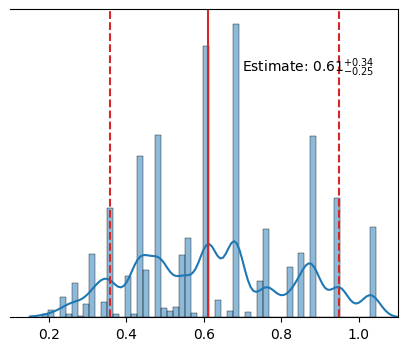

In [102]:
import matplotlib.pyplot as plt
ax = cp.density(wsurvival_all, figsize=(5, 4), xlim=(0.1, 1.1))
ax.set_yticklabels([])
ax.tick_params(axis='y', which='both', left=False)
ax.set_ylabel(None)
ax.spines['left'].set_visible(False)
plt.savefig('./outputs/dens_works.pdf')

On fait de même avec Minsample, pour obtenir une estimation minimale du taux de survie des manuscrits.

In [84]:
dsurvival_all = u.survival_ratio(abundance, method='minsample', n_iter=1000)

  0%|                                                                           | 0/1000 [00:00<?, ?it/s]/home/jbcamps/Data/Cours/Cours-ENC-2024-25/Memoires/Guidi/IberianChurchFather_tradition/copia-eg/lib/python3.10/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 25.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/home/jbcamps/Data/Cours/Cours-ENC-2024-25/Memoires/Guidi/IberianChurchFather_tradition/copia-eg/lib/python3.10/site-packages/copia/richness.py:453: UserWarning: Optimization failure likely: 0.0 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
 36%|██████████████████████▉                                         | 359/1000 [00:03<00:06, 102.46it/s]/home/jbcamps/Data/Cours/Cours-ENC-2024-25/Memoires/Guidi/IberianChurchFather_tradition/copia-eg/lib/python3.10/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 35.0 > 0.1
  warnings.warn(f"Tolerance criterion not me

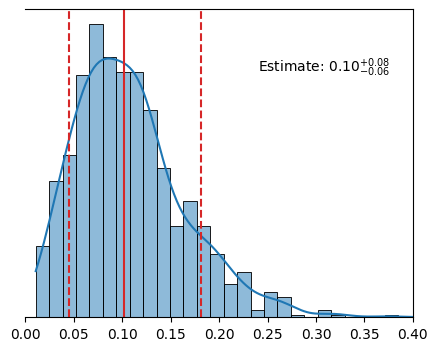

In [85]:
ax = cp.density(dsurvival_all, figsize=(5, 4), xlim=(0.0, 0.4))
ax.set_yticklabels([])
ax.tick_params(axis='y', which='both', left=False)
ax.set_ylabel(None)
ax.spines['left'].set_visible(False)
plt.savefig('./outputs/dens_docs.pdf')

# Partie IV : La courbe d'accumulation des espèces (section 1.3)

On rappelle que cette dernière donne une idée de combien de manucrits il resterait à trouver afin de trouver encore de nouveaux textes. La fonction `species_accumulation` permet de la tracer.


In [86]:
max_steps = 20000 # on fixe un nombre qui soit réaliste de notre corpus
accumulation = cp.species_accumulation(abundance, max_steps=max_steps)

100%|██████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


/tmp/ipykernel_134124/3188207797.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


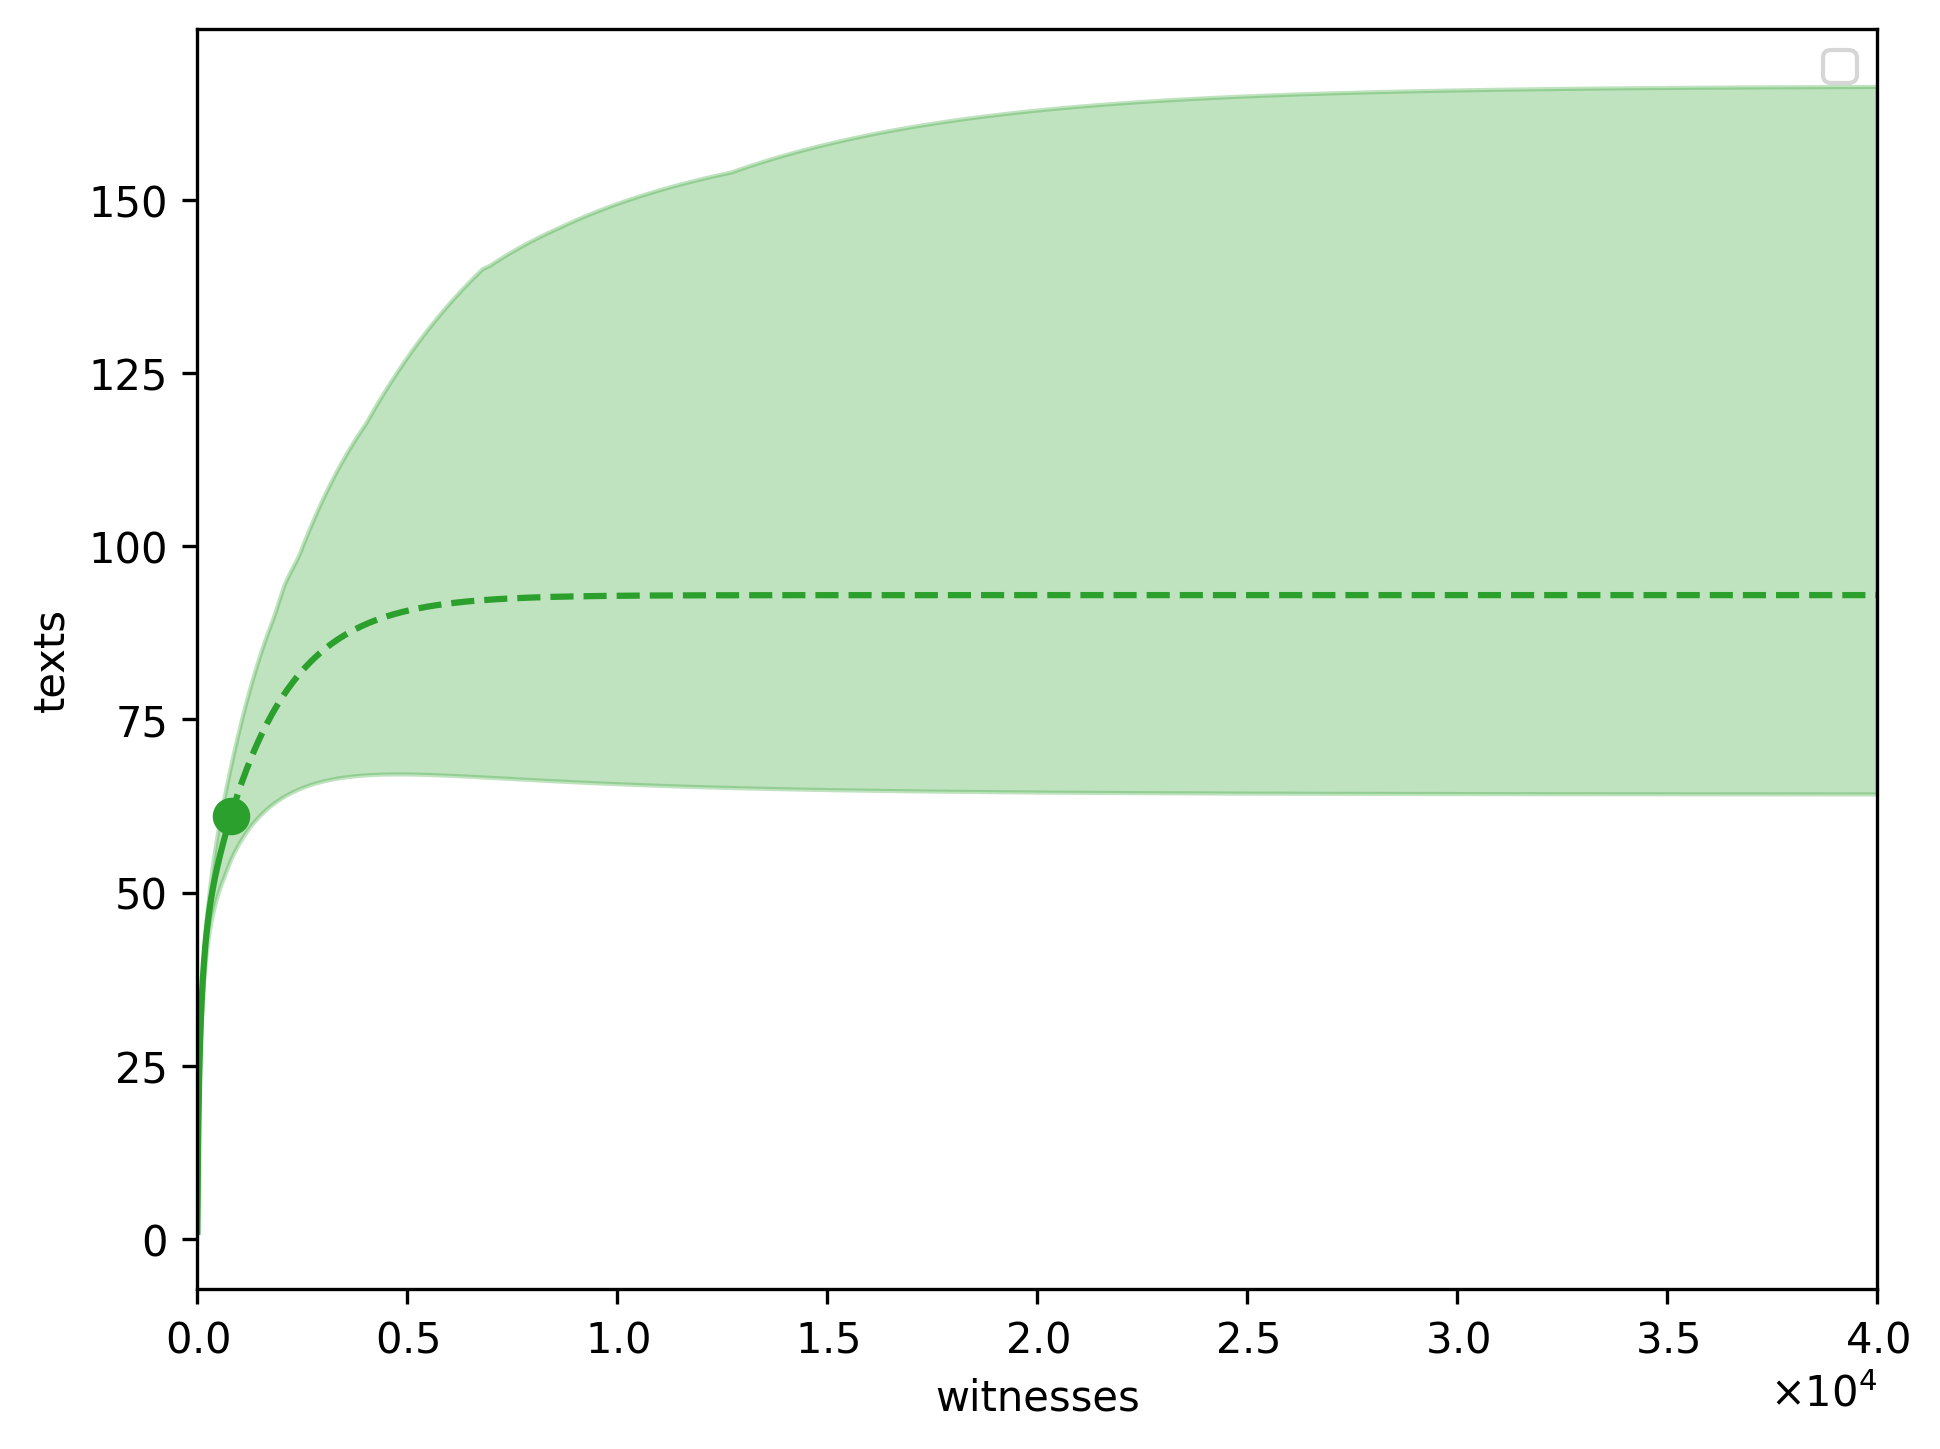

In [87]:
# Paramètres pour la position de la courbe d'accumulation
left, bottom, width, height = [0.44, 0.45, 0.35, 0.35]
fig = plt.figure(figsize=(16, 12), dpi = 300)

# On créé l'axe secondaire pour la courbe d'accumulation
ax2 = fig.add_axes([left, bottom, width, height])

# On trace la courbe d'accumulation des espèces sans titre mais avec une légende
cp.accumulation_curve(abundance, accumulation, c0='C2', c1='C2',
                   xlabel='witnesses', ylabel='texts',
                   ax=ax2, xlim=(0, max_steps), label='Accumulation')

# Ajout de la légende
ax2.legend()

# Formatage des axes
ax2.tick_params(axis='y', which='minor', left=False)
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)

plt.show()

Petite fonction personnelle (rendons à César ce qui est à César!) afin de trouver le point précis où la courbe s'aplatit (cela veut dire qu'il n'est plus probable de trouver de nouveaux textes).

In [49]:
import numpy as np

def detect_flattening(accumulation, 
                      key='richness', threshold=0.001, plot=True):
    """
    Détecte le point où la courbe d'accumulation commence à s'aplatir.

    accumulation : dict contenant les données de richesse.
    abundance : données d’abondance à transmettre à accumulation_curve.
    max_steps : borne maximale pour l’axe des x.
    key : clé de la richesse dans le dictionnaire accumulation.
    threshold : seuil sous lequel la courbe est considérée comme plate.
    plot : si True, affiche la courbe avec la ligne d'aplatissement.
    """
    richness = accumulation.get(key)
    
    if richness is None:
        raise ValueError(f"Mince, C=clé '{key}' non trouvée dans le dictionnaire...")
    
    diffs = np.diff(richness)
    flattened_indices = np.where(diffs < threshold)[0]

    if len(flattened_indices) > 0:
        first_flattened = flattened_indices[0] + 1  # +1 car np.diff réduit la taille
        print(f"La courbe commence à s'aplatir autour du texte numéro {first_flattened}")
    else:
        first_flattened = None
        print("La courbe ne s'aplatit pas dans l'intervalle observé, peu probable...")

    if plot:
        fig, ax = plt.subplots(figsize=(8, 6))

        # On reprend le graphique précédent
        cp.accumulation_curve(abundance, accumulation,
                           c0='C2', c1='C2',
                           xlabel='témoins', ylabel='textes',
                           ax=ax,
                           xlim=(0, max_steps))

        # Et on ajoute tout simplement une ligne rouge pour signaler l'aplatissement
        if first_flattened is not None:
            ax.axvline(x=first_flattened, color='red', linestyle='--')
            ax.legend()

        ax.tick_params(axis='y', which='minor', left=False)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)

        plt.tight_layout()
        plt.show()

    return first_flattened


La courbe commence à s'aplatir autour du texte numéro 7314


/tmp/ipykernel_134124/4103474940.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


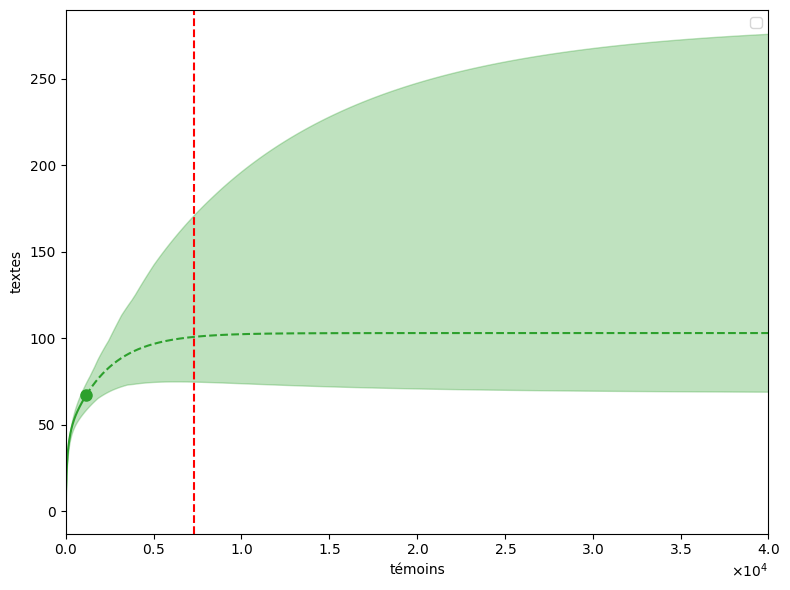

np.int64(7314)

In [50]:
#On applique la fonction et on attend le résultat...
detect_flattening(accumulation)

# Partie V :  Le nombre de Hill (section 1.4)

Le nombre de Hill est un indicateur de diversité qui combine la richesse et l’abondance des espèces.  
En faisant varier la valeur de ***q***, on obtient différentes mesures de la diversité :  
- pour ***q = 0***, on considère uniquement la richesse spécifique (nombre d’espèces) ;  
- pour ***q = 1***, on obtient un indice équivalent à celui de Shannon-Weaver ;  
- pour ***q = 2***, on se rapproche de l’indice de Simpson.  


In [89]:
# -*- coding: utf-8 -*-
"""
Hill number calculations (including evenness calculations)
"""
from functools import partial

import numpy as np
from scipy.special import digamma
from scipy.special import binom as choose

import copia.stats as stats

def _chao_7a(t, n, f1, f2):
    return (t + (n - 1) / n * ((f1**2 / 2 / f2) if f2 > 0 else
                               (f1 * (f1 - 1) / 2)))


def _chao_7b(x, n, f1, p1):
    A = np.sum(x / n * (digamma(n) - digamma(x)))
    if f1 == 0 or p1 == 1:
        B = 0
    else:
        B = f1 / n * (1 - p1)**(1. - n)
        r = np.arange(1, n)
        B *= (-np.log(p1) - np.sum((1 - p1)**r / r))
    return np.exp(A + B)


def _chao_7c(x, q, n):
    A = np.sum(np.exp(stats.lchoose(x, q) - stats.lchoose(n, q)))
    return np.nan if A == 0 else A**(1 / (1 - q))


def _chao_7d(x, n, f1, p1, q):
    data, counts = np.unique(x, return_counts=True)
    term = np.zeros(data.shape[0])
    zi = stats.lchoose(n, data)
    for i, z in enumerate(data):
        k = np.arange(n - z + 1)
        term[i] = np.sum(
            choose(k - q, k) * np.exp(stats.lchoose(n - k - 1, z - 1) - zi[i]))
    A = np.sum(counts * term)
    if f1 == 0 or p1 == 1:
        B = 0
    else:
        B = f1 / n * (1 - p1)**(1. - n)
        r = np.arange(n)
        B *= (p1**(q - 1)) - np.sum(choose(q - 1, r) * (p1 - 1) ** r)
    return (A + B)**(1 / (1 - q))


def estimated_hill(x, q_values):
    """
    Estimated Hill numbers
    """
    x, n = x[x > 0], x.sum()
    t = x.shape[0]  # number of nonzero traits
    f1 = np.count_nonzero(x == 1)
    f2 = np.count_nonzero(x == 2)

    p1 = 1  # cf equation 6b
    if f2 > 0:
        p1 = 2 * f2 / ((n - 1) * f1 + 2 * f2)
    elif f1 > 0:
        p1 = 2 / ((n - 1) * (f1 - 1) + 2)

    def sub(q):
        # equation 7a
        if q == 0:
            return _chao_7a(t, n, f1, f2)
        # equation 7b
        elif q == 1:
            return _chao_7b(x, n, f1, p1)
        elif abs(q - round(q)) == 0:
            return _chao_7c(x, q, n)
        else:
            return _chao_7d(x, n, f1, p1, q)

    return np.array([sub(q) for q in q_values])


def empirical_hill(x, q_values):
    """
    Empirical Hill numbers
    """
    p = x[x > 0] / x.sum()

    def sub(q):
        return ((x > 0).sum() if q == 0 else np.exp(-np.sum(p * np.log(p)))
                if q == 1 else np.exp(1 / (1 - q) * np.log(np.sum(p**q))))

    return np.array([sub(q) for q in q_values])


def hill_numbers(x, q_min=0, q_max=3, step=0.1,
                 n_iter=1000, conf=0.95, n_jobs=1, seed=None):
    x = np.array(x, dtype=np.int64)
    q = np.arange(q_min, q_max + step, step)

    emp = stats.bootstrap(x, fn=partial(empirical_hill, q_values=q),
                    n_iter=n_iter,
                    conf=conf,
                    n_jobs=n_jobs,
                    seed=seed)

    est = stats.bootstrap(x, fn=partial(estimated_hill, q_values=q),
                    n_iter=n_iter,
                    conf=conf,
                    n_jobs=n_jobs,
                    seed=seed)
    return emp, est

__all__ = ['estimated_hill', 'empirical_hill', 'hill_numbers']

In [90]:
emp, est = hill_numbers(abundance, n_iter=1000, n_jobs=4)

100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.26it/s]


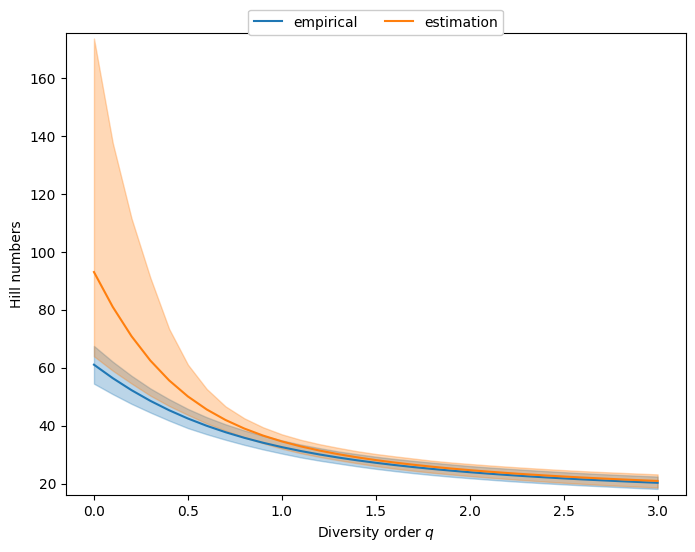

In [91]:
fig, ax = plt.subplots(figsize=(8, 6))
cp.hill_plot(emp, est, add_densities=False, ax=ax)
plt.show()

# Partie VI : L'équitabilité (section 1.5)

L’équitabilité est un indicateur utilisé en biologie pour évaluer si une communauté est équilibrée.  
Un profil d’équitabilité décroissant indique un déséquilibre : certaines espèces sont très représentées, tandis que d’autres ne le sont que faiblement.  
Dans notre cas, cela signifie qu’un texte représenté par un seul individu a plus de chances d’être perdu, ce qui augmente le risque de disparition de certains contenus. La fonction `evenness` permet de générer ce profil.


In [92]:
# Calcul de l'équitabilité 
evenness_result = u.evenness(est)
print(evenness_result)

[1.         0.86926829 0.75917033 0.66805745 0.59364035 0.53334486
 0.48462467 0.44517404 0.41303253 0.38660605 0.36463753 0.34615521
 0.33041649 0.3168568  0.30504692 0.29465922 0.28544189 0.27719955
 0.26977891 0.26305826 0.25693973 0.25134364 0.24620436 0.24146719
 0.23708613 0.23302208 0.22924159 0.22571582 0.22241974 0.21933152
 0.21643204]


Remarque : La fonction evenness_plot est prévue à la base pour traiter plusieurs séries de données sous forme de dictionnaire (pour le projet ***Forgotten Books***, un profil d'équitabilité est généré pour chaque langue), avec des labels associés à chaque série. Comme nous n'avons qu'une seule série sous forme d'array, il suffit de la placer dans un dictionnaire avant de la passer à la fonction.

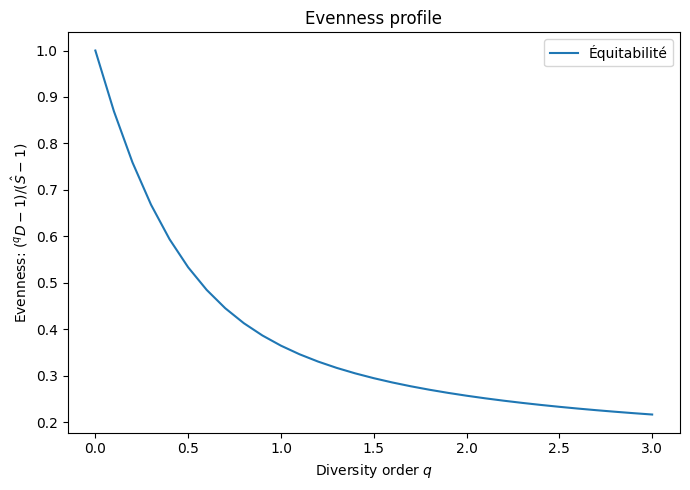

In [93]:
evenness_result_dict = {'Équitabilité': evenness_result}

ax = cp.evenness_plot(evenness_result_dict, figsize=(7, 5))
plt.tight_layout()
plt.savefig('./outputs/evenness.pdf')
plt.show()
